In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体（显示中文）
from tqdm import tqdm
import datetime

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

from importlib import reload
import utils
reload(utils)
from utils import seed_everything,get_data
seed_everything(2023)

In [2]:
info_map={
    'daily_min_temperatures.csv':{'freq':'d','pdq':(3,0,1)},
    'weather.csv':{'freq':'10min','pdq':(4,0,1)},
    'exchange_rate.csv':{'freq':'d','pdq':(0,1,1)},
    'ETTh1.csv':{'freq':'h','pdq':(2,0,5)},
    'traffic.csv':{'freq':'h','pdq':(2,0,1)},
    'electricity.csv':{'freq':'h','pdq':(5,0,0)},
}
class CFG:
    path = 'electricity.csv'
    p,d,q=info_map[path]['pdq']
    freq=info_map[path]['freq']
    scaler = ''
    
args=CFG()

In [3]:
data,train,valid,test = get_data(args.path)

if args.scaler != '':
	assert args.scaler in ['minmax','std']
	if args.scaler == 'std':
		scaler = StandardScaler().fit(train.values.reshape(-1, 1))
	elif args.scaler == 'minmax':
		scaler = MinMaxScaler().fit(train.values.reshape(-1, 1))

	data = pd.Series(index=data.index,data=scaler.transform(data.values.reshape(-1,1)).flatten())
	train = pd.Series(index=train.index,data=scaler.transform(train.values.reshape(-1,1)).flatten())
	valid = pd.Series(index=valid.index,data=scaler.transform(valid.values.reshape(-1,1)).flatten())
	test = pd.Series(index=test.index,data=scaler.transform(test.values.reshape(-1,1)).flatten())

In [4]:
train.index = pd.PeriodIndex(train.index,freq=args.freq) # 为了让模型记住时间，不然后面预测的时候会报错
model = sm.tsa.arima.ARIMA(train, order = (args.p,args.d,args.q))
model = model.fit()
# model.summary()

In [5]:
true_cases = test.values
predicted_cases = model.predict(start=test.index.min(),end=test.index.max()).values

true_cases_valid = valid.values
predicted_cases_valid = model.predict(start=valid.index.min(),end=valid.index.max()).values

true_cases_all = data.values
predicted_cases_all = model.predict(start=data.index.min(),end=data.index.max()).values

if args.scaler != '':
	true_cases = scaler.inverse_transform(np.expand_dims(true_cases, axis=0)).flatten()
	predicted_cases = scaler.inverse_transform(np.expand_dims(predicted_cases, axis=0)).flatten()

	true_cases_valid = scaler.inverse_transform(np.expand_dims(true_cases_valid, axis=0)).flatten()
	predicted_cases_valid = scaler.inverse_transform(np.expand_dims(predicted_cases_valid, axis=0)).flatten()

	true_cases_all = scaler.inverse_transform(np.expand_dims(true_cases_all, axis=0)).flatten()
	predicted_cases_all = scaler.inverse_transform(np.expand_dims(predicted_cases_all, axis=0)).flatten()

print(f'all: mse={mean_squared_error(true_cases_all,predicted_cases_all)} mae={mean_absolute_error(true_cases_all,predicted_cases_all)}')
print(f'valid: mse={mean_squared_error(true_cases_valid,predicted_cases_valid)} mae={mean_absolute_error(true_cases_valid,predicted_cases_valid)}')
print(f'test: mse={mean_squared_error(true_cases,predicted_cases)} mae={mean_absolute_error(true_cases,predicted_cases)}')

# electricity
# all: mse=28663.832547872604 mae=112.56318048204523
# valid: mse=221486.5252894837 mae=416.0176935960871
# test: mse=192403.35663964247 mae=385.81057630646956

# traffic
# all: mse=3.5658636408207786e-05 mae=0.003489775941976964
# valid: mse=0.0007314049331157986 mae=0.02117860258540671
# test: mse=0.0005618904879707521 mae=0.02056671543042975

# ETTh1
# all: mse=1.0883014912795428 mae=0.6621686195916598
# valid: mse=6.459386385086415 mae=1.959920231655244
# test: mse=22.303415323944282 mae=4.439210481493964

# exchange_rate
# all: mse=7.09822516395371e-05 mae=0.003311856807536415
# valid: mse=0.00010949982659245037 mae=0.008370595691665084
# test: mse=0.00017045494982891436 mae=0.010294554630658799

# weather
# all: mse=6.860422963941569 mae=1.324306049051638
# valid: mse=17.257268102349062 mae=3.3153444339009166
# test: mse=12.793695541129473 mae=3.0585639208505686

# daily_min_temperatures
# all: mse=5.847751826452781 mae=1.8933863604592667
# valid: mse=6.3922606422321016 mae=1.9229397467968572
# test: mse=10.03178887453495 mae=2.4026584529298383

all: mse=28663.832547872604 mae=112.56318048204523
valid: mse=221486.5252894837 mae=416.0176935960871
test: mse=192403.35663964247 mae=385.81057630646956


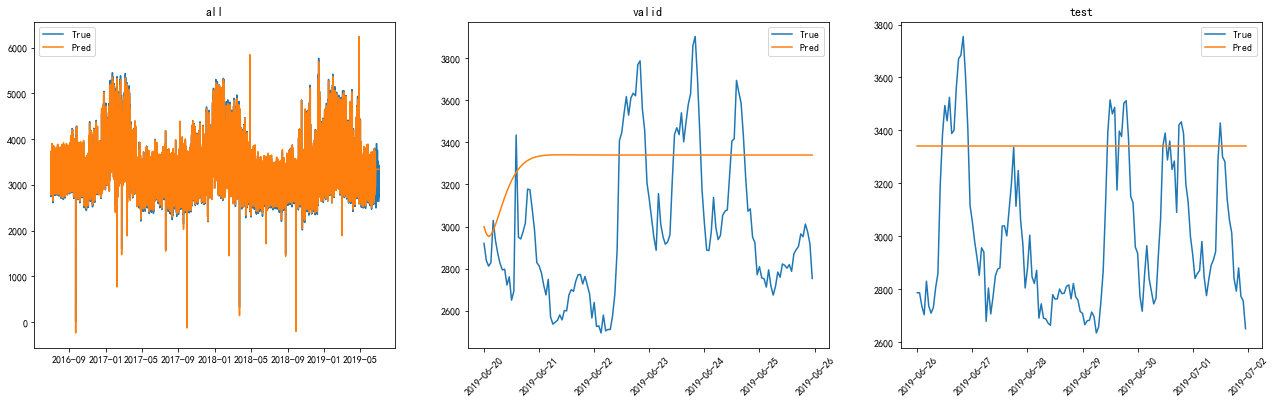

In [7]:
fig,ax=plt.subplots(1,3,figsize=(22,6))
ax[0].plot(data.index,true_cases_all,label='True')
ax[0].plot(data.index,predicted_cases_all,label='Pred')
ax[0].set_title('all')
ax[0].legend()
ax[1].plot(valid.index,true_cases_valid,label='True')
ax[1].plot(valid.index,predicted_cases_valid,label='Pred')
ax[1].set_title('valid')
ax[1].legend()
ax[1].tick_params(axis='x', labelrotation=45)
ax[2].plot(test.index,true_cases,label='True')
ax[2].plot(test.index,predicted_cases,label='Pred')
ax[2].set_title('test')
ax[2].legend()
ax[2].tick_params(axis='x', labelrotation=45)
plt.show()

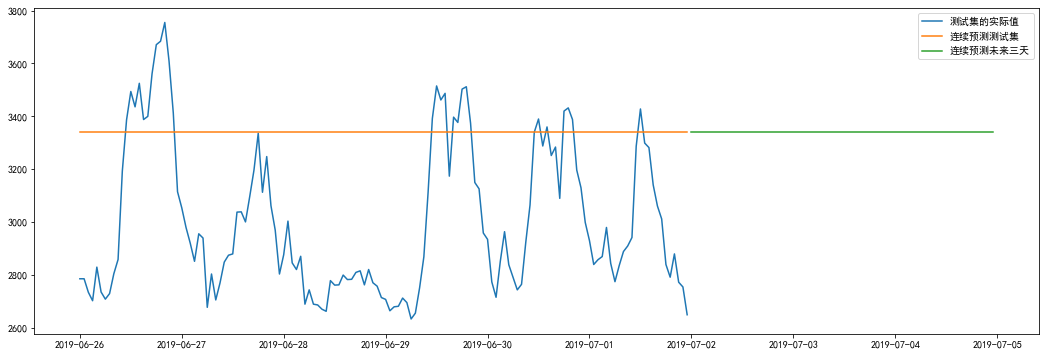

In [8]:
fig,ax=plt.subplots(1,1,figsize=(18,6))
if args.path in ['ETTh1.csv','traffic.csv','electricity.csv']:
    DAYS_TO_PREDICT = 3 * 24
    future = pd.Series(index=pd.date_range(start=data.index.max()+datetime.timedelta(hours=1),periods=DAYS_TO_PREDICT,freq=args.freq))
    label='连续预测未来三天'
elif args.path == 'weather.csv':
    DAYS_TO_PREDICT = 1 * 6 * 24
    future = pd.Series(index=pd.date_range(start=data.index.max()+datetime.timedelta(minutes=10),periods=DAYS_TO_PREDICT,freq=args.freq))
    label='连续预测未来一天'
elif args.path in ['daily_min_temperatures.csv','exchange_rate.csv']:
    DAYS_TO_PREDICT = 31
    future = pd.Series(index=pd.date_range(start=data.index.max()+datetime.timedelta(days=1),periods=DAYS_TO_PREDICT))
    label='连续预测未来一个月'

future_forecast = model.predict(start=future.index.min(),end=future.index.max())
future_pred = future_forecast.values
if args.scaler != '':
    future_pred = scaler.inverse_transform(np.expand_dims(future_pred, axis=0)).flatten()
ax.plot(test.index,true_cases,label='测试集的实际值')
ax.plot(test.index,predicted_cases,label='连续预测测试集')
ax.plot(future.index,future_pred,label=label)
ax.legend()
plt.show()

100%|██████████| 144/144 [06:58<00:00,  2.91s/it]


all: mse=26565.286298146988 mae=109.16087982747621
valid: mse=17170.275696878503 mae=89.86295344341968
test: mse=13734.915657322292 mae=91.04544700028988


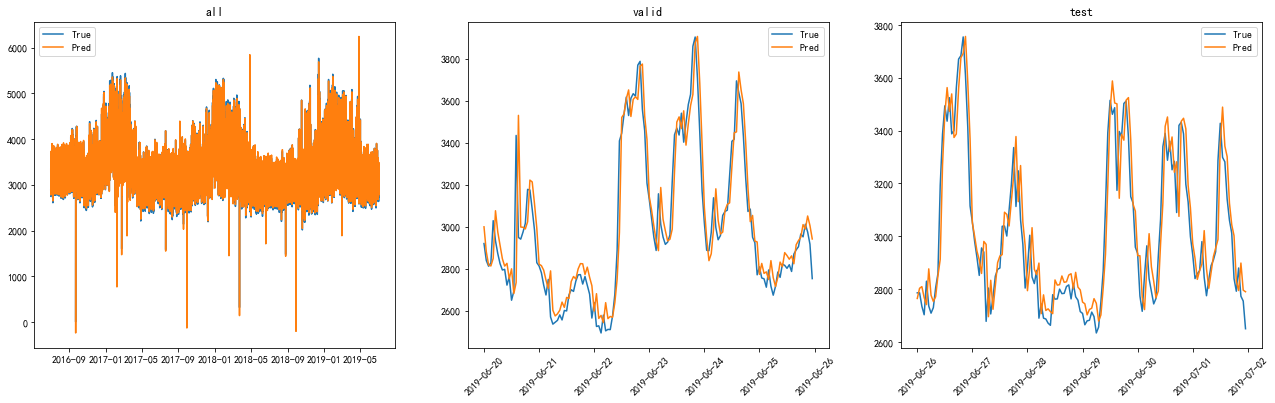

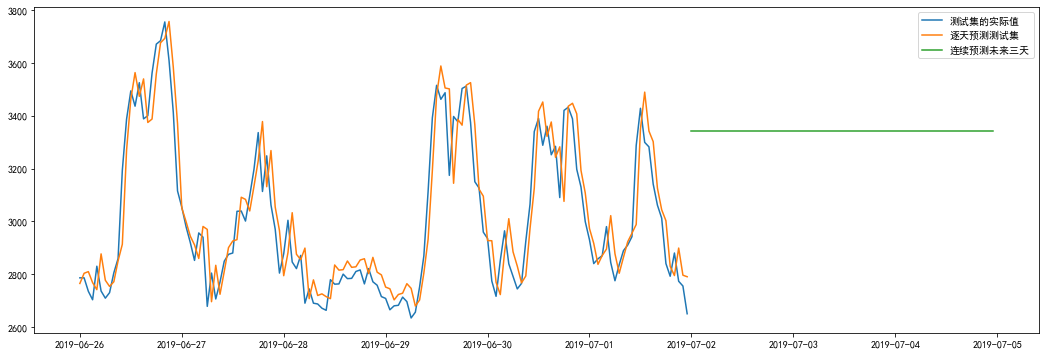

In [9]:
# https://www.kaggle.com/code/puja07/time-series-analysis-using-arima-model

def one_by_one_train_and_pred(train_data,pred_data):
	history = train_data.values.tolist()
	y = pred_data.values.tolist()
	predictions = list()

	# Model Buliding
	# Rolling Forecasts
	for i in tqdm(range(len(y))):
		# Predict
		model = sm.tsa.arima.ARIMA(history, order=(args.p,args.d,args.q))
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		# Observations
		history.append(y[i])
	
	return np.array(predictions)

true_cases = test.values
predicted_cases = one_by_one_train_and_pred(pd.concat([train,valid]),test)

true_cases_valid = valid.values
predicted_cases_valid = one_by_one_train_and_pred(train,valid)

model = sm.tsa.arima.ARIMA(train, order = (args.p,args.d,args.q))
model = model.fit()
true_cases_all = data.values
predicted_cases_all = np.array(model.predict(start=train.index.min(),end=train.index.max()).values.tolist() + predicted_cases_valid.tolist() + predicted_cases.tolist())

if args.scaler != '':
	true_cases = scaler.inverse_transform(np.expand_dims(true_cases, axis=0)).flatten()
	predicted_cases = scaler.inverse_transform(np.expand_dims(predicted_cases, axis=0)).flatten()

	true_cases_valid = scaler.inverse_transform(np.expand_dims(true_cases_valid, axis=0)).flatten()
	predicted_cases_valid = scaler.inverse_transform(np.expand_dims(predicted_cases_valid, axis=0)).flatten()

	true_cases_all = scaler.inverse_transform(np.expand_dims(true_cases_all, axis=0)).flatten()
	predicted_cases_all = scaler.inverse_transform(np.expand_dims(predicted_cases_all, axis=0)).flatten()

print(f'all: mse={mean_squared_error(true_cases_all,predicted_cases_all)} mae={mean_absolute_error(true_cases_all,predicted_cases_all)}')
print(f'valid: mse={mean_squared_error(true_cases_valid,predicted_cases_valid)} mae={mean_absolute_error(true_cases_valid,predicted_cases_valid)}')
print(f'test: mse={mean_squared_error(true_cases,predicted_cases)} mae={mean_absolute_error(true_cases,predicted_cases)}')

fig,ax=plt.subplots(1,3,figsize=(22,6))
ax[0].plot(data.index,true_cases_all,label='True')
ax[0].plot(data.index,predicted_cases_all,label='Pred')
ax[0].set_title('all')
ax[0].legend()
ax[1].plot(valid.index,true_cases_valid,label='True')
ax[1].plot(valid.index,predicted_cases_valid,label='Pred')
ax[1].set_title('valid')
ax[1].legend()
ax[1].tick_params(axis='x', labelrotation=45)
ax[2].plot(test.index,true_cases,label='True')
ax[2].plot(test.index,predicted_cases,label='Pred')
ax[2].set_title('test')
ax[2].legend()
ax[2].tick_params(axis='x', labelrotation=45)
plt.show()

model = sm.tsa.arima.ARIMA(train, order = (args.p,args.d,args.q))
model = model.fit()
if args.path in ['ETTh1.csv','traffic.csv','electricity.csv']:
	DAYS_TO_PREDICT = 3
	future = model.predict(start=data.index.max()+datetime.timedelta(hours=1),end=data.index.max()+datetime.timedelta(days=DAYS_TO_PREDICT))
	label='连续预测未来三天'
elif args.path == 'weather.csv':
	DAYS_TO_PREDICT = 1
	future = model.predict(start=data.index.max()+datetime.timedelta(minutes=10),end=data.index.max()+datetime.timedelta(days=DAYS_TO_PREDICT))
	label='连续预测未来一天'
elif args.path in ['daily_min_temperatures.csv','exchange_rate.csv']:
	DAYS_TO_PREDICT = 31
	future = model.predict(start=data.index.max()+datetime.timedelta(days=1),end=data.index.max()+datetime.timedelta(days=DAYS_TO_PREDICT))
	label='连续预测未来一个月'

future_pred = future.values
if args.scaler != '':
	future_pred = scaler.inverse_transform(np.expand_dims(future_pred, axis=0)).flatten()
fig,ax=plt.subplots(1,1,figsize=(18,6))
ax.plot(test.index,true_cases,label='测试集的实际值')
ax.plot(test.index,predicted_cases,label='逐天预测测试集')
ax.plot(future.index.to_timestamp(),future_pred,label=label)
ax.legend()
plt.show()

# electricity
# all: mse=26565.286298146988 mae=109.16087982747621
# valid: mse=17170.275696878503 mae=89.86295344341968
# test: mse=13734.915657322292 mae=91.04544700028988

# traffic
# all: mse=2.620703549171367e-05 mae=0.003217349786338976
# valid: mse=0.00012538474743568033 mae=0.005425064546173348
# test: mse=1.7965895477419255e-05 mae=0.0031750712003746307

# ETTh1
# all: mse=0.8565190118956975 mae=0.6157489350423649
# valid: mse=0.41039639738630895 mae=0.4030866174899937
# test: mse=0.34535571942973753 mae=0.3869988792860763

# exchange_rate
# all: mse=7.001988028329544e-05 mae=0.0032587352531950457
# valid: mse=1.7155474188709414e-05 mae=0.0027094727476424637
# test: mse=2.278244272613557e-05 mae=0.0027258770461855617

# weather
# all: mse=6.786384129253381 mae=1.311365952470461
# valid: mse=1.3052355417106178 mae=0.8175323062805988
# test: mse=1.7215534405797042 mae=0.8332407963413024

# daily_min_temperatures
# all: mse=5.795908770551495 mae=1.8859580404463674
# valid: mse=5.772103587834295 mae=1.8762061001351766
# test: mse=4.524494406162047 mae=1.572780540437619